In [1]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.tools import get_lcao_hamiltonian, remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import (cutcoupling, rotate_matrix,
                            subdiagonalize_atoms)


[tigu:1798522] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


### Plot settings

In [2]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

### Control parameters

In [3]:
GPWDIR = '../dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
SUBDIAG_SPECIES = ("C")
ACTIVE_REGION = {'C':3}

### Locally defined functions

In [4]:
def get_species_indices(species,atoms):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

In [5]:
lowdin = True
cc_path = Path(GPWDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

## Unclear if LCAOWrap does something different from get_lcao_hamiltonian

# lcao = LCAOwrap(calc)
# H_lcao = lcao.get_hamiltonian()
# S_lcao = lcao.get_overlap()
# H_lcao -= fermi * S_lcao

H_skMM, S_kMM = get_lcao_hamiltonian(calc)
H_lcao = H_skMM[0,0] - fermi * S_kMM[0]
S_lcao = S_kMM[0]
remove_pbc(atoms, H_lcao, S_lcao, d=0)

In [6]:
bridge_indices = get_species_indices(BRIDGE_SPECIES,atoms)
print(bridge_indices)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]
print(bridge_orbital_indices)

[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
[612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719
 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737
 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755]


## LCAO Hamiltonian (Hamiltonian obtained directly from gpaw)

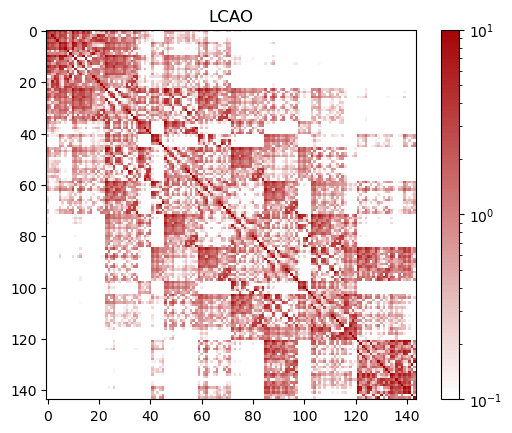

In [7]:
bridge_region_H_lcao = H_lcao[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_lcao), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("LCAO")
plt.show()

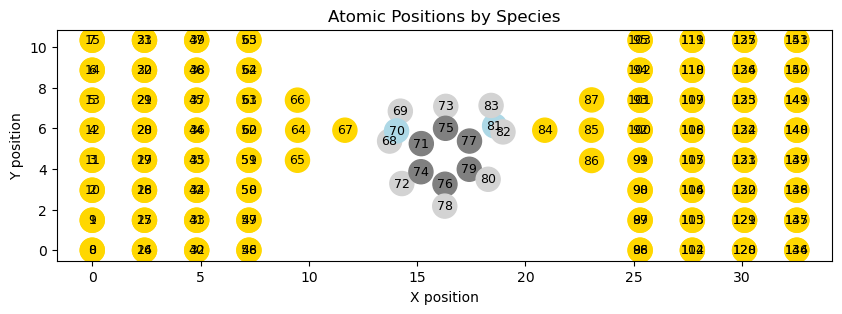

In [8]:
element_colors = {
    "Au": "gold",
    "C": "gray",
    'H': 'lightgray',
    'N': 'lightblue'
}

def plot_atomic_positions_by_species(atoms, element_colors):
    fig, ax = plt.subplots(figsize=(10, 3))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title('Atomic Positions by Species')

    plt.show()

plot_atomic_positions_by_species(atoms, element_colors)

In [9]:
subdiag_indices = get_species_indices(SUBDIAG_SPECIES,atoms)
print(subdiag_indices)

# TODO External/internal indices to be determined from the plot above

external_indices = [71,77]
internal_indices = [i for i in subdiag_indices if i not in external_indices]
print(external_indices)
print(internal_indices)

[71, 74, 75, 76, 77, 79]
[71, 77]
[74, 75, 76, 79]


In [10]:
C_basis = basis[subdiag_indices]
C_orbital_indices = C_basis.get_indices()
print(C_orbital_indices)

external_basis = basis[external_indices]
external_orbital_indices = external_basis.get_indices()
print(external_orbital_indices)

internal_basis = basis[internal_indices]
internal_orbital_indices = internal_basis.get_indices()
print(internal_orbital_indices)

[635 636 637 638 639 640 641 642 643 644 645 646 647 658 659 660 661 662
 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680
 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698
 699 700 701 702 703 704 705 706 707 708 709 715 716 717 718 719 720 721
 722 723 724 725 726 727]
[635 636 637 638 639 640 641 642 643 644 645 646 647 697 698 699 700 701
 702 703 704 705 706 707 708 709]
[658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675
 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693
 694 695 696 715 716 717 718 719 720 721 722 723 724 725 726 727]


In [11]:
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_sub = rotate_matrix(H_lcao, Usub)
S_sub = rotate_matrix(S_lcao, Usub)
bridge_region_H_sub = H_sub[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_sub = S_sub[bridge_start:bridge_end+1,bridge_start:bridge_end+1]

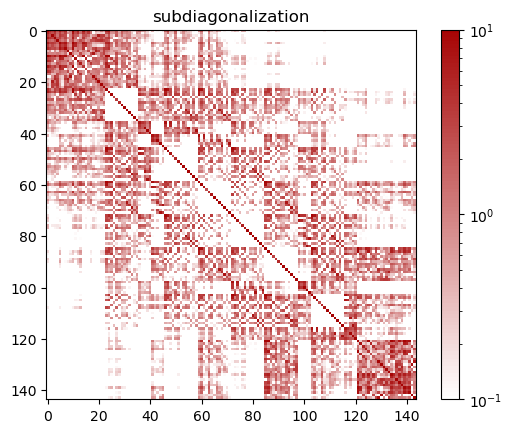

In [12]:
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
# cax = ax.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization")
plt.show()

### Cut coupling C 2pz chosen to be the active region

In [13]:
active_region_indices = basis_bridge.extract().take(ACTIVE_REGION)
H_cutcoupled = deepcopy(H_sub)
S_cutcoupled = deepcopy(S_sub)
cutcoupling(H_cutcoupled,S_cutcoupled, bridge_orbital_indices[active_region_indices])

In [14]:
np.save("C_2pz/hs_cutcoupled.npy",(H_cutcoupled[None, ...],S_cutcoupled[None, ...]))

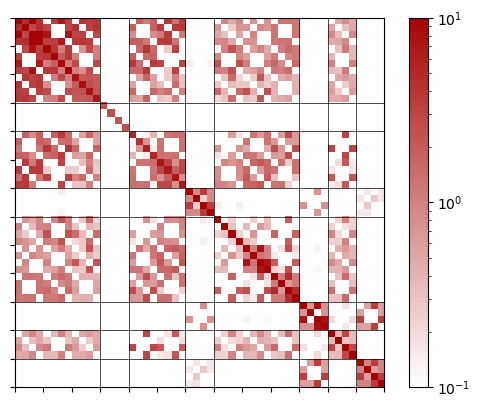

In [35]:
num_orbitals_per_atom = 13
num_atoms = len(internal_indices)
new_order_idx = []
for orb in range(num_orbitals_per_atom):
    for atom in range(num_atoms):
        new_order_idx.append(internal_orbital_indices[atom * num_orbitals_per_atom + orb])

Hcutcoupled_internal_sorted = np.zeros((len(new_order_idx), len(new_order_idx)))
Scutcoupled_internal_sorted = np.zeros((len(new_order_idx), len(new_order_idx)))

for i in range(len(new_order_idx)):
    for j in range(len(new_order_idx)):
        Hcutcoupled_internal_sorted[i, j] = np.abs(H_cutcoupled[new_order_idx[i], new_order_idx[j]])
        Scutcoupled_internal_sorted[i, j] = np.abs(S_cutcoupled[new_order_idx[i], new_order_idx[j]])

fig, ax = plt.subplots()
cax = ax.imshow(Hcutcoupled_internal_sorted, interpolation='none', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)

ticks = np.arange(-0.5, num_orbitals_per_atom * num_atoms, num_atoms)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels([])
ax.set_yticklabels([])

# TODO lines are to be determined per case

line_indices = np.array([11.5, 15.5, 23.5, 27.5, 39.5, 43.5, 47.5])
for idx in line_indices:
    ax.axhline(y=idx, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(x=idx, color='black', linestyle='-', linewidth=0.5)

plt.show()

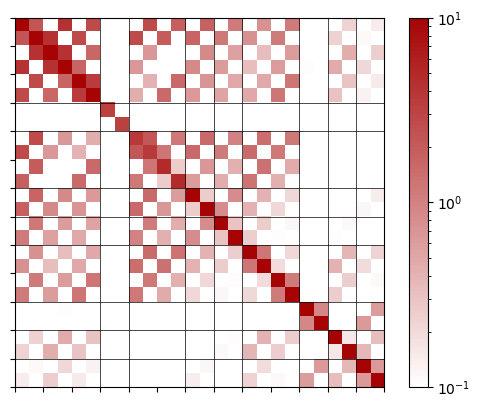

In [36]:
num_orbitals_per_atom = 13
num_atoms = len(external_indices)
new_order_idx = []
for orb in range(num_orbitals_per_atom):
    for atom in range(num_atoms):
        new_order_idx.append(external_orbital_indices[atom * num_orbitals_per_atom + orb])

Hcutcoupled_external_sorted = np.zeros((len(new_order_idx), len(new_order_idx)))
Scutcoupled_external_sorted = np.zeros((len(new_order_idx), len(new_order_idx)))

for i in range(len(new_order_idx)):
    for j in range(len(new_order_idx)):
        Hcutcoupled_external_sorted[i, j] = np.abs(H_cutcoupled[new_order_idx[i], new_order_idx[j]])
        Scutcoupled_external_sorted[i, j] = np.abs(S_cutcoupled[new_order_idx[i], new_order_idx[j]])

fig, ax = plt.subplots()
cax = ax.imshow(Hcutcoupled_external_sorted, interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)

ticks = np.arange(-0.5, num_orbitals_per_atom * num_atoms, num_atoms)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels([])
ax.set_yticklabels([])
line_indices = np.array([5.5, 7.5, 11.5,13.5,15.5,19.5,21.5,23.5, 25.5])
for idx in line_indices:
    ax.axhline(y=idx, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(x=idx, color='black', linestyle='-', linewidth=0.5)

plt.show()